In [2]:
#First, let us import the necessary libraries.
from pandas_datareader import data as web
import numpy as np
import pandas as pd
from sklearn import mixture as mix
import seaborn as sns 
#import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV as rcv
from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import Imputer
import matplotlib.pyplot as plt
from IPython import get_ipython

In [3]:
#Then we fetch the OHLC data from Google and shift it by one day to train the algorithm only on the past data.
avg_err={}
avg_train_err={}

df= web.get_data_yahoo('SPY',start= '2000-01-01', end='2017-01-01')
df=df[['Open','High','Low','Close']]
df['open']=df['Open'].shift(1)
df['high']=df['High'].shift(1)
df['low']=df['Low'].shift(1)
df['close']=df['Close'].shift(1)

df=df[['open','high','low','close']]

In [4]:
#Then drop all the NaN.

df=df.dropna()

In [5]:
#Next, we will instantiate an unsupervised machine learning algorithm using the "Gaussian mixture" model from sklearn.

unsup = mix.GaussianMixture(n_components=3, 
                            covariance_type="spherical", 
                            n_init=100, 
                            random_state=42)

In [6]:
"""
In the above code, I created an unsupervised-algo that will divide the market into 4 regimes, based on the criterion of 
its own choosing. We have not provided any train dataset with labels like in the previous section of the Python machine learning tutorial.
"""

'\nIn the above code, I created an unsupervised-algo that will divide the market into 4 regimes, based on the criterion of \nits own choosing. We have not provided any train dataset with labels like in the previous section of the Python machine learning tutorial.\n'

In [7]:
#Next, we will fit the data and predict the regimes. Then we will be storing these regime predictions in a new variable called regime.

unsup.fit(np.reshape(df,(-1,df.shape[1])))
regime = unsup.predict(np.reshape(df,(-1,df.shape[1])))

#Now let us calculate the returns of the day.
df['Return']= np.log(df['close']/df['close'].shift(1))

In [8]:
#Then, create a dataframe called Regimes which will have the OHLC and Return values along with the corresponding regime classification.

Regimes=pd.DataFrame(regime,columns=['Regime'],index=df.index)\
                     .join(df, how='inner')\
                          .assign(market_cu_return=df.Return.cumsum())\
                                 .reset_index(drop=False)\
                                             .rename(columns={'index':'Date'})

C:\Users\Noah\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\Noah\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


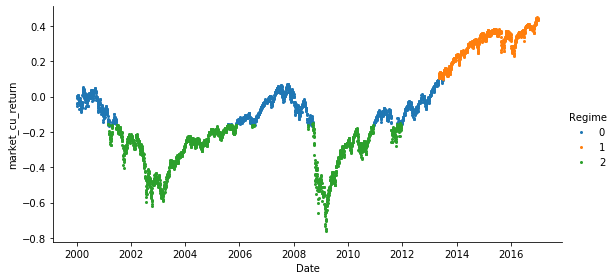

In [9]:
#After this, let us create a list called 'order' that has the values corresponding to the regime classification, and then plot these values to see how well the algo has classified.

order=[0,1,2]
fig = sns.FacetGrid(data=Regimes,hue='Regime',hue_order=order,aspect=2,size= 4)
fig.map(plt.scatter,'Date','market_cu_return', s=4).add_legend()
plt.show()

In [10]:
"""
This graph looks pretty good to me. Without actually looking at the factors based on which the classification was done, we can conclude a few things just by looking at the chart.

The red zone is the low volatility or the sideways zone
The purple zone is high volatility zone or panic zone.
The green zone is a breakout zone.
The blue zone: Not entirely sure but let us find out
"""

'\nThis graph looks pretty good to me. Without actually looking at the factors based on which the classification was done, we can conclude a few things just by looking at the chart.\n\nThe red zone is the low volatility or the sideways zone\nThe purple zone is high volatility zone or panic zone.\nThe green zone is a breakout zone.\nThe blue zone: Not entirely sure but let us find out\n'

In [11]:
#Use the code below to print the relevant data for each regime

for i in order:
    print('Mean for regime %i: '%i,unsup.means_[i][0])
    print('Co-Variancefor regime %i: '%i,(unsup.covariances_[i]))

Mean for regime 0:  138.09607504562925
Co-Variancefor regime 0:  81.2233575241695
Mean for regime 1:  197.2889148787758
Co-Variancefor regime 1:  249.57508258644486
Mean for regime 2:  107.12039675758527
Co-Variancefor regime 2:  155.33214885718792


In [46]:
#PREDICTING DAILY CLOSE WHILE COMPARING TO REGIM

